# Association Rules

## What are Association Rules?
1. Study of what goes with what
- Customers who bought product X also bought product Y
- What symptoms go with what medical diagnosis 
2. Transaction-based or event-based
3. Referred to also as `market basket analysis` and `affinity analysis`
4. Originated with study of customer transactions databases to determine associations among items purchased

## Used in many recommender systems

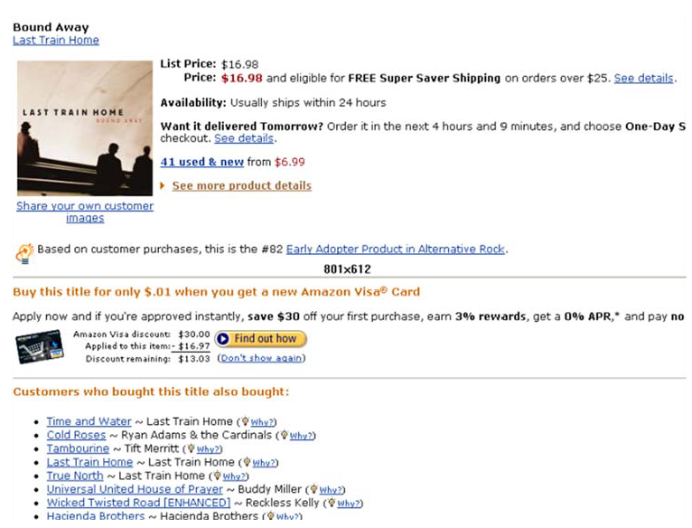

In [1]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd

import heapq
from collections import defaultdict

# one needs to install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# one needs to install scikit-surprise
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Generating Rules

### Terms used

- `IF` part = antecedent
- `THEN` part = consequent
- `Item set` = items that the antecedent or consequent are referring to 

Antecedent and consequent must be disjoint (no items can be in common within the two in any one rule)

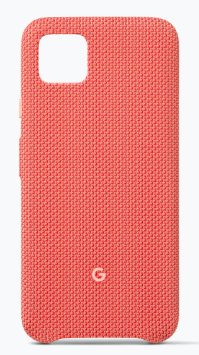

In [3]:
fp_df = pd.read_csv('datasets/Faceplate.csv')
fp_df.set_index('Transaction', inplace=True)

print(fp_df)

             Red  White  Blue  Orange  Green  Yellow
Transaction                                         
1              1      1     0       0      1       0
2              0      1     0       1      0       0
3              0      1     1       0      0       0
4              1      1     0       1      0       0
5              1      0     1       0      0       0
6              0      1     1       0      0       0
7              1      0     1       0      0       0
8              1      1     1       0      1       0
9              1      1     1       0      0       0
10             0      0     0       0      0       1


## Many Rules are Possible

For example: Transaction 1 supports several rules, such as 

1. `If` red, `then` white (If a red faceplate is purchased, then so is a white one)
2. `If` white, `then` red
3. `If` red and white, `then` green”
4. obviously, many more rules can be generated
 

## Frequent Item Sets
Ideally, we want to create all possible combinations of items

- `Problem`: computation time grows exponentially as the number of items increases
- `Solution`: consider only the most frequent item sets

Criterion for definition of frequent = support

## Support
- `Support for an itemset` = number (or percent) of transactions that include an itemset. 
    - `Example`: support for the item set {red, white} is 4 out of 10 transactions, or 40%
    -
- `Support for a rule` = number (or percent) of transactions that include both the antecedent and the consequent

## Apriori Algorithm

## Generating Frequent Item Sets

For `k` number of products:

1. User sets a minimum support criterion
2. Next, generate list of one-item sets that meet the support criterion
3. Use the list of one-item sets to generate list of two-item sets that meet the support criterion
4. Use list of two-item sets to generate list of three-item sets

Continue up through `k` item sets

## Measures of Rule Performance

`Confidence`: the % of antecedent transactions that also have the consequent item set

`Benchmark confidence` = transactions with consequent as % of all transactions

`Lift` = confidence/(benchmark confidence)

`Lift` > 1 indicates a rule that is useful in finding consequent items sets (i.e., more useful than just selecting transactions randomly)

`Leverage` = Prob(antecedent AND consequent) - Prob(antecedent) x Prob(consequent)

`Leverage` = 0 when the two items are independent.

`Leverage` ranges from -1 (antecedent and consequent are antagonistic) to +1 (antecedent makes consequent more likely)

In [4]:
# create frequent itemsets
itemsets = apriori(fp_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

       antecedents   consequents  support  confidence      lift  leverage
14    (White, Red)       (Green)      0.2         0.5  2.500000      0.12
15         (Green)  (White, Red)      0.2         1.0  2.500000      0.12
4          (Green)         (Red)      0.2         1.0  1.666667      0.08
12  (White, Green)         (Red)      0.2         1.0  1.666667      0.08
7         (Orange)       (White)      0.2         1.0  1.428571      0.06
8          (Green)       (White)      0.2         1.0  1.428571      0.06


In [5]:
# filter to get rules with single consequents only
rules[[len(c) == 1 for c in rules.consequents]].sort_values(by=['lift'], ascending=False).head(6)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,"(White, Red)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
12,"(White, Green)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
13,"(Red, Green)",(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf


The apriori method accepts sparse data frames as well. If we convert the original data frame to sparse format, we can see that the memory requirements go down to 40%. 

In [6]:
# Convert data set into a sparse data frame
# sparse_df = fp_df.to_sparse(fill_value=0)
dtype = {key: pd.SparseDtype(fp_df.dtypes[key].type, fill_value=fp_df[key].value_counts().argmax()) 
         for key in fp_df.dtypes.keys()}
sparse_df = fp_df.astype(dtype)
print(f'Density {sparse_df.sparse.density:.2f}')

# create frequent itemsets
itemsets = apriori(sparse_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head(100)

Density 0.40


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,"(White, Red)",(Green),0.4,0.2,0.2,0.500000,2.500000,0.12,1.600000
15,(Green),"(White, Red)",0.2,0.4,0.2,1.000000,2.500000,0.12,inf
4,(Green),(Red),0.2,0.6,0.2,1.000000,1.666667,0.08,inf
12,"(White, Green)",(Red),0.2,0.6,0.2,1.000000,1.666667,0.08,inf
7,(Orange),(White),0.2,0.7,0.2,1.000000,1.428571,0.06,inf
8,(Green),(White),0.2,0.7,0.2,1.000000,1.428571,0.06,inf
13,"(Red, Green)",(White),0.2,0.7,0.2,1.000000,1.428571,0.06,inf
2,(Blue),(Red),0.6,0.6,0.4,0.666667,1.111111,0.04,1.200000
3,(Red),(Blue),0.6,0.6,0.4,0.666667,1.111111,0.04,1.200000
0,(White),(Red),0.7,0.6,0.4,0.571429,0.952381,-0.02,0.933333


### Rule 14

`Confidence` = Prob(green) if you use the rule = 0.5

`Lift` = How much better are the chances of getting a green if you use this rule than if you were to randomly select?  2.500000

## Interpretation

`Lift ratio` and `leverage` show how effective the rule is in finding consequents (useful if finding particular consequents is important)

`Confidence` shows the rate at which consequents will be found (useful in learning costs of promotion)  

`Support` measures overall impact

## Caution: The Role of Chance

Random data can generate apparently interesting association rules.  The more rules you produce, the greater this danger.

Rules based on large numbers of records are less subject to this danger.

In [7]:
from itertools import chain
randomTransactions = [{8}, {3,4,8}, {8}, {3,9}, {9}, {1,8}, {6,9}, {3,5,7,9}, {8}, set(), 
                      {1,7,9}, {1,4,5,8,9}, {5,7,9}, {6,7,8}, {3,7,9}, {1,4,9}, {6,7,8}, {8}, set(), {9},
                      {2,5,6,8}, {4,6,9}, {4,9}, {8,9}, {6,8}, {1,6,8}, {5,8}, {4,8,9}, {9}, {8},
                      {1,5,8}, {3,6,9}, {7,9}, {7,8,9}, {3,4,6,8}, {1,4,8}, {4,7,8}, {8,9}, {4,5,7,9}, {2,8,9},
                      {2,5,9}, {1,2,7,9}, {5,8}, {1,7,8}, {8}, {2,7,9}, {4,6,9}, {9}, {9}, {6,7,8}]

uniqueItems = sorted(set(chain.from_iterable(randomTransactions)))
randomData = pd.DataFrame(0, index=range(len(randomTransactions)), columns=uniqueItems)
for row, transaction in enumerate(randomTransactions):
    for item in transaction:
        randomData.loc[row][item] = 1
randomData.head()

,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


In [8]:
# create frequent itemsets
itemsets = apriori(randomData, min_support=2/len(randomData), use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.7)
print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

  antecedents consequents  support  confidence      lift  leverage
3      (8, 3)         (4)     0.04         1.0  4.545455    0.0312
1      (1, 5)         (8)     0.04         1.0  1.851852    0.0184
2      (2, 7)         (9)     0.04         1.0  1.851852    0.0184
4      (3, 4)         (8)     0.04         1.0  1.851852    0.0184
5      (3, 7)         (9)     0.04         1.0  1.851852    0.0184
6      (4, 5)         (9)     0.04         1.0  1.851852    0.0184


## Example: Charles Book Club

In [9]:
# load dataset
all_books_df = pd.read_csv('datasets\CharlesBookClub.csv')

# create the binary incidence matrix
ignore = ['Seq#', 'ID#', 'Gender', 'M', 'R', 'F', 'FirstPurch', 'Related Purchase',
          'Mcode', 'Rcode', 'Fcode', 'Yes_Florence', 'No_Florence']
count_books = all_books_df.drop(columns=ignore)
count_books[count_books > 0] = 1
print(count_books.head())

   ChildBks  YouthBks  CookBks  DoItYBks  RefBks  ArtBks  GeogBks  ItalCook  \
0         0         1        1         0       0       0        0         0   
1         0         0        0         0       0       0        0         0   
2         1         1        1         0       1       0        1         1   
3         0         0        0         0       0       0        0         0   
4         0         0        0         0       0       0        0         0   

   ItalAtlas  ItalArt  Florence  
0          0        0         0  
1          0        0         0  
2          0        0         0  
3          0        0         0  
4          0        0         0  


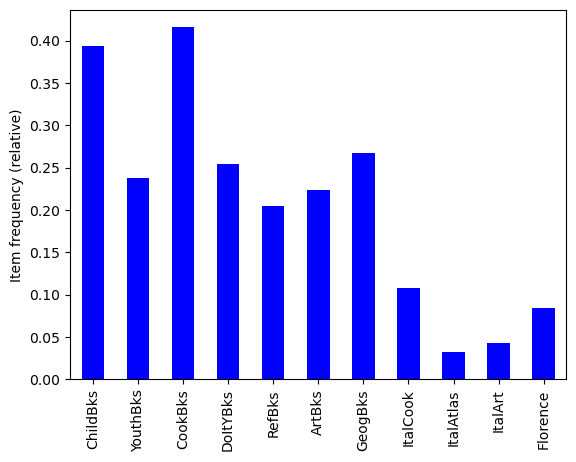

In [10]:
# determine item frequencies
itemFrequency = count_books.sum(axis=0) / len(count_books)

ax = itemFrequency.plot.bar(color='blue')
plt.ylabel('Item frequency (relative)')
plt.show()

In [11]:
# create frequent itemsets and rules
itemsets = apriori(count_books, min_support=200/4000, use_colnames=True)
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)

print('Number of rules', len(rules))

# Display 25 rules with highest lift
rules.sort_values(by=['lift'], ascending=False).head(25)

pd.set_option('display.width', 100)
print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(25))


Number of rules 81
                      antecedents          consequents  support  confidence      lift  leverage
64             (RefBks, YouthBks)  (CookBks, ChildBks)  0.05525    0.680000  2.809917  0.035588
73             (RefBks, DoItYBks)  (CookBks, ChildBks)  0.06125    0.662162  2.736207  0.038865
60           (DoItYBks, YouthBks)  (CookBks, ChildBks)  0.06700    0.648910  2.681448  0.042014
80              (RefBks, GeogBks)  (CookBks, ChildBks)  0.05025    0.614679  2.539995  0.030467
69            (YouthBks, GeogBks)  (CookBks, ChildBks)  0.06325    0.605263  2.501087  0.037961
77            (DoItYBks, GeogBks)  (CookBks, ChildBks)  0.06050    0.599010  2.475248  0.036058
66   (CookBks, ChildBks, GeogBks)           (YouthBks)  0.06325    0.577626  2.424452  0.037162
71    (RefBks, CookBks, ChildBks)           (DoItYBks)  0.06125    0.591787  2.323013  0.034883
47            (DoItYBks, GeogBks)           (YouthBks)  0.05450    0.539604  2.264864  0.030437
62    (RefBks, CookBk

In [12]:
# Filter rules by number of antecedents (maximum 2) and consequents (maximum 1)
rules = rules[[len(c) <= 2 for c in rules.antecedents]]
rules = rules[[len(c) == 1 for c in rules.consequents]]

print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(10))

             antecedents consequents  support  confidence      lift  leverage
47   (DoItYBks, GeogBks)  (YouthBks)  0.05450    0.539604  2.264864  0.030437
34    (RefBks, ChildBks)  (DoItYBks)  0.07100    0.553606  2.173135  0.038328
20   (ChildBks, GeogBks)  (YouthBks)  0.07550    0.516239  2.166797  0.040656
45    (CookBks, GeogBks)  (YouthBks)  0.08025    0.513600  2.155719  0.043023
17  (ChildBks, YouthBks)  (DoItYBks)  0.08025    0.544068  2.135693  0.042674
50     (RefBks, CookBks)  (DoItYBks)  0.07450    0.533095  2.092619  0.038899
23   (CookBks, ChildBks)  (DoItYBks)  0.12775    0.527893  2.072198  0.066101
48   (YouthBks, GeogBks)  (DoItYBks)  0.05450    0.521531  2.047227  0.027879
41   (CookBks, YouthBks)  (DoItYBks)  0.08375    0.520186  2.041948  0.042735
43    (RefBks, YouthBks)   (CookBks)  0.06825    0.840000  2.021661  0.034491


## Summary – Association Rules

- Association rules (or affinity analysis, or market basket analysis) produce rules on associations between items from a database of transactions
- Widely used in recommender systems
- Most popular method is Apriori algorithm
- To reduce computation, we consider only frequent item sets (=support)
- Performance of rules is measured by confidence and lift
- Can produce a profusion of rules; review is required to identify useful rules and to reduce redundancy